# Identification

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, FOPDT, FOPDT_cost, SOPDT, SOPDT_cost

# Load data

In [8]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_MV_2024-03-11-09h21.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values
     
print(ExpVariable)    

MV


# Plot cleaned data

(0.0, 665.0)

<Figure size 2200x2200 with 0 Axes>

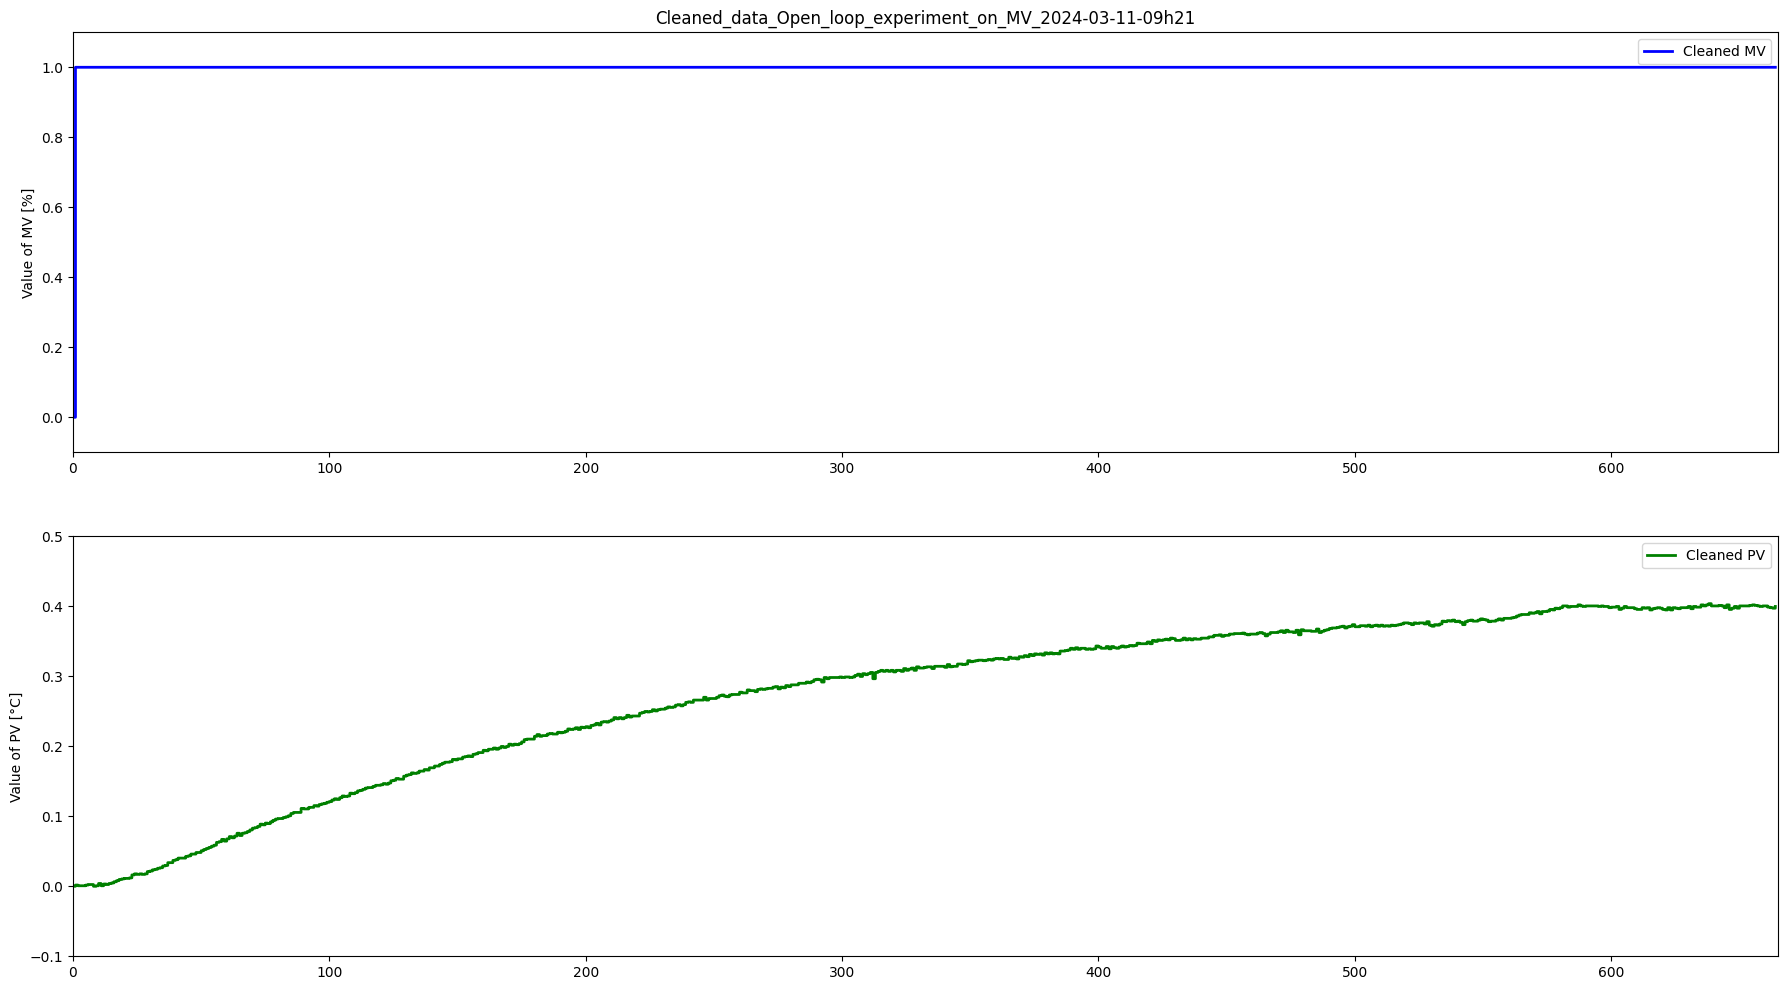

In [9]:
plt.figure(figsize = (22,22))

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(22)

if ExpVariable == 'MV':
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned MV',where='post')
    ax1.set_ylabel('Value of MV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,MVm)
    ax1.set_ylim(myRound(np.min(MVm),1)-0.1, myRound(np.max(MVm),1)+0.1)    
else:
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned DV',where='post')
    ax1.set_ylabel('Value of DV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,DVm)
    ax1.set_ylim(myRound(np.min(DVm),1)-0.1, myRound(np.max(DVm),1)+0.1)     

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='Cleaned PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')
l2.set_data(tm,PVm)
ax2.set_ylim(myRound(np.min(PVm),0.1)-0.1, myRound(np.max(PVm),0.1)+0.1)

ax1.set_xlim(0, tm[-1]+1)
ax2.set_xlim(0, tm[-1]+1)

# Optimisation parameters

In [10]:
Ts = 1.0
model = 'FOPDT'

maxIter = 500

if model == 'FOPDT':
    bnds = ((None, None), (0, None), (0, None))
    p0 = np.zeros(3)
    p0[0] = 0.5 # K
    p0[1] = 100.0 # T
    p0[2] = 10.0 # theta

    if ExpVariable == 'MV':
        cost = FOPDT_cost(p0,MVm,PVm,Ts)
    else:
        cost = FOPDT_cost(p0,DVm,PVm,Ts)
else:
    bnds = ((None, None), (0, None), (0, None), (0, None))    
    p0 = np.zeros(4)
    p0[0] = 0.65 # K
    p0[1] = 100.0 # T1
    p0[2] = 20.0 # T2
    p0[3] = 10.0 # theta

    if ExpVariable == 'MV':
        cost = SOPDT_cost(p0,MVm,PVm,Ts)
    else:
        cost = SOPDT_cost(p0,DVm,PVm,Ts)        
    
print('Initial cost: ' + str(cost))

Initial cost: 14.858058973155126


# Optimisation

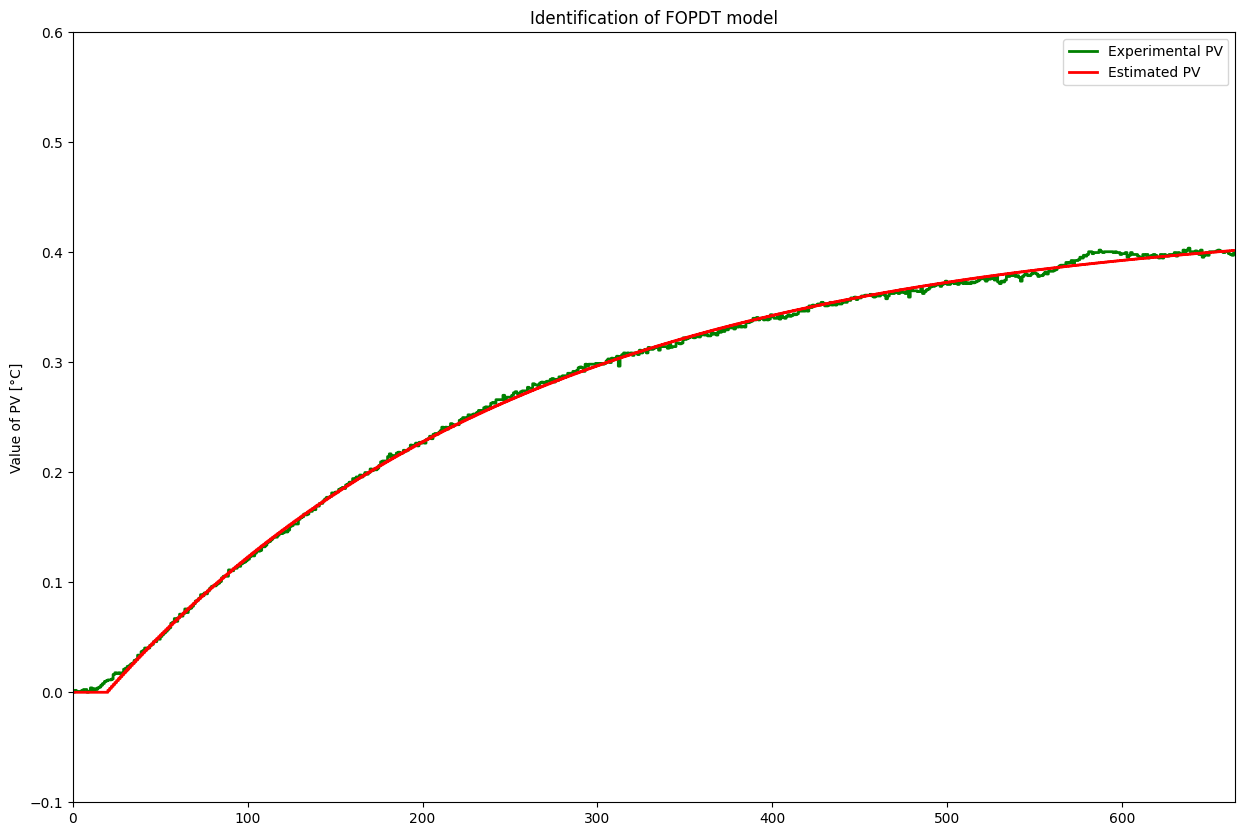

Final SSE Objective: 0.006789555207616607
K: 0.43117146633002806
T: 240.06677879648248
theta: 18.702701935008474


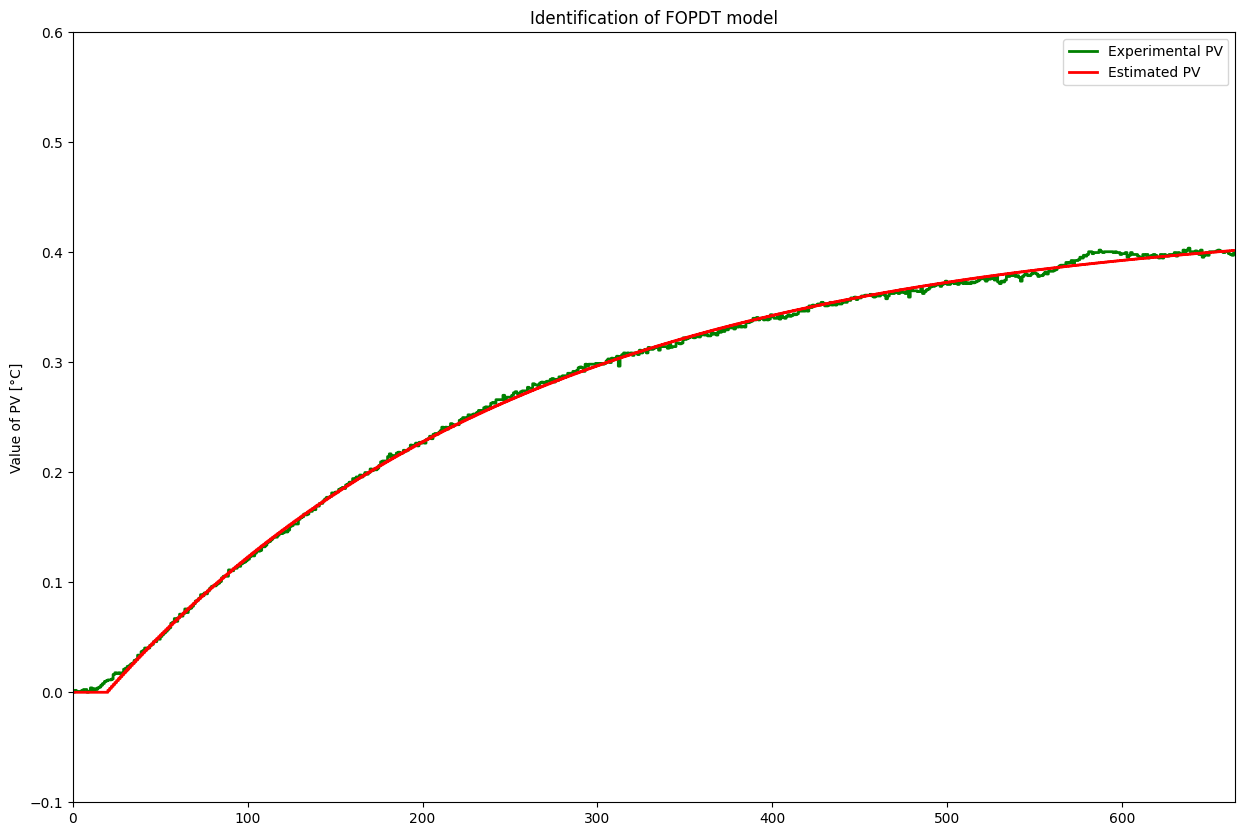

In [11]:
# optimize K, T, theta

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
l1, = ax1.step([0,1],[0,1],'g-',linewidth=2,label='Experimental PV',where='post')
l2, = ax1.step([0,1],[0,1],'r-',linewidth=2,label='Estimated PV',where='post')
ax1.set_ylabel('Value of PV [°C]')
ax1.legend(loc='best')

if model == 'FOPDT':
    ax1.set_title('Identification of FOPDT model')
    if ExpVariable == 'MV':
        solution = minimize(FOPDT_cost,p0,args=(MVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
        p = solution.x
        print('Final SSE Objective: ' + str(FOPDT_cost(p,MVm,PVm,Ts)))
    else:
        solution = minimize(FOPDT_cost,p0,args=(DVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
        p = solution.x
        print('Final SSE Objective: ' + str(FOPDT_cost(p,DVm,PVm,Ts)))

    K = p[0]
    T = np.max([0,p[1]])
    theta  = np.max([0,p[2]])

    print('K: ' + str(K))
    print('T: ' + str(T))
    print('theta: ' + str(theta))
else:
    ax1.set_title('Identification of SOPDT model')
    if ExpVariable == 'MV':
        solution = minimize(SOPDT_cost,p0,args=(MVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})
        p = solution.x
        print('Final SSE Objective: ' + str(SOPDT_cost(p,MVm,PVm,Ts)))
    else:
        solution = minimize(SOPDT_cost,p0,args=(DVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
        p = solution.x
        print('Final SSE Objective: ' + str(SOPDT_cost(p,DVm,PVm,Ts)))

    K = p[0]
    T1 = np.max([0,p[1]])
    T2 = np.max([0,p[2]])
    theta  = np.max([0,p[3]])

    print('K: ' + str(K))
    print('T1: ' + str(T1))
    print('T2: ' + str(T2))
    print('theta: ' + str(theta))    

# Plot experimental and simulated data

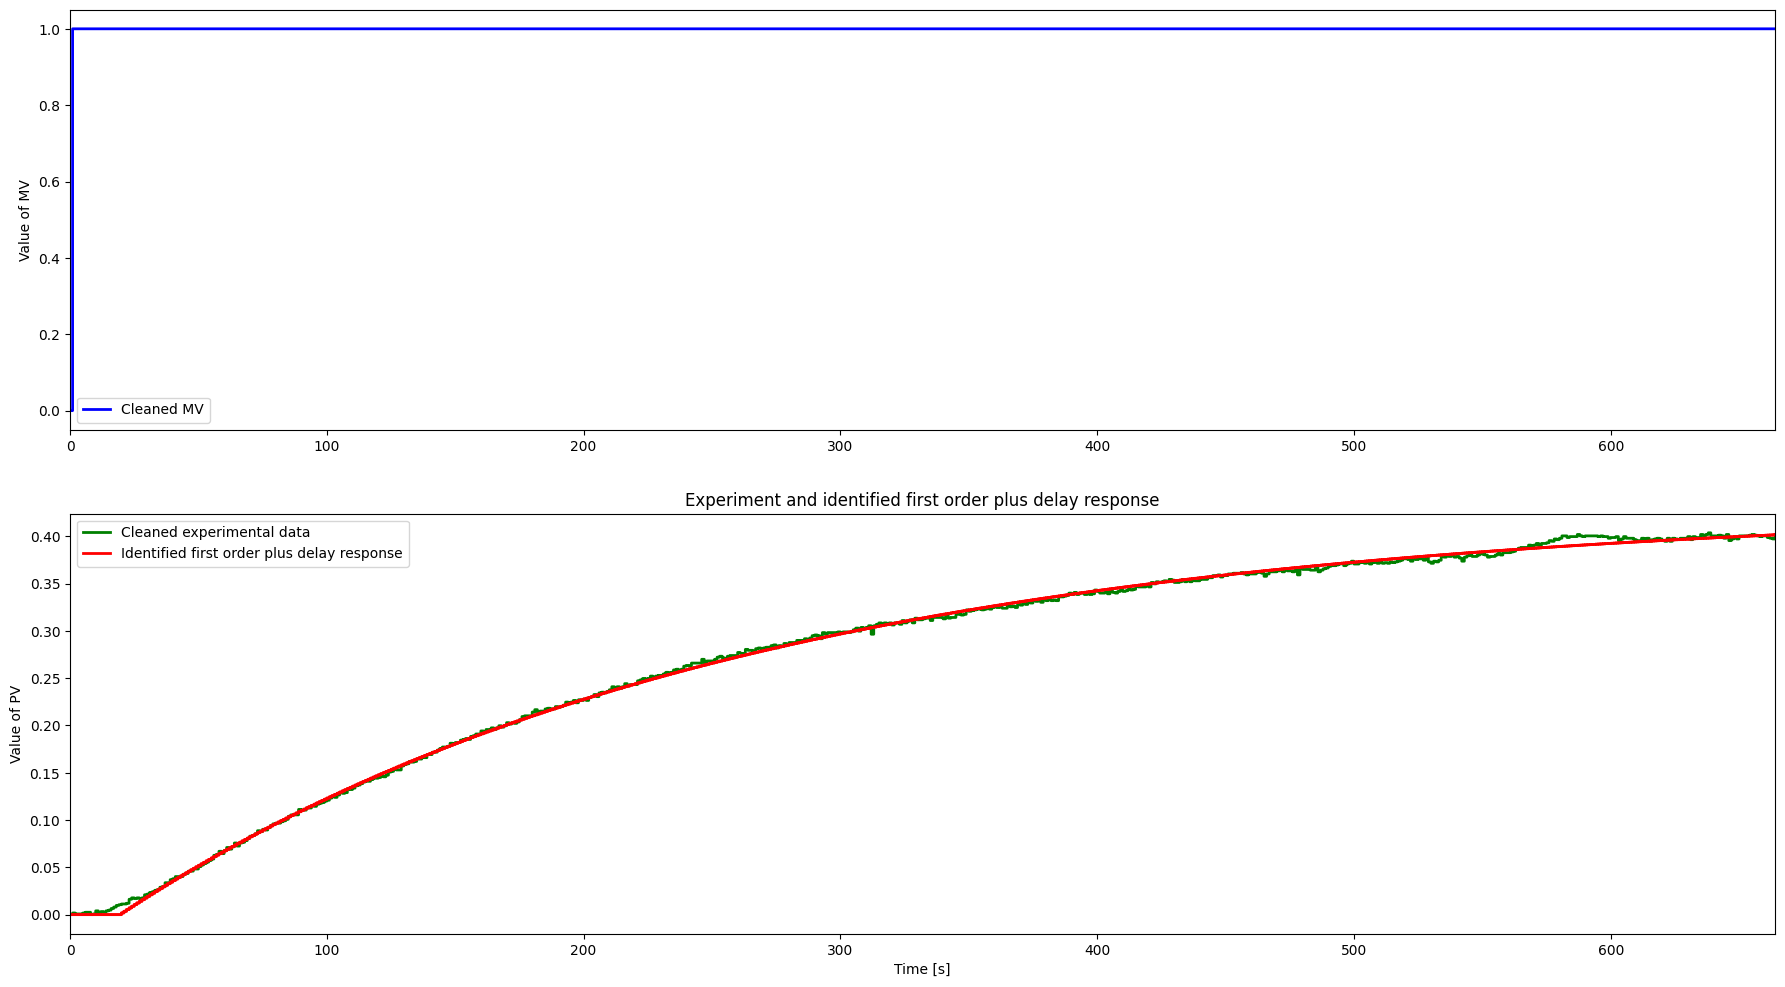

In [12]:
if model == 'FOPDT':
    if ExpVariable == 'MV':
        PVSim = FOPDT(MVm,K,T,theta,Ts)
    else:
        PVSim = FOPDT(DVm,K,T,theta,Ts)    
else:
    if ExpVariable == 'MV':
        PVSim = SOPDT(MVm,K,T1,T2,theta,Ts)
    else:
        PVSim = SOPDT(DVm,K,T1,T2,theta,Ts)      
        
plt.figure(figsize = (22,12))

plt.subplot(2,1,1)
if ExpVariable == 'MV':
    plt.step(tm,MVm,'b-',linewidth=2,label='Cleaned MV',where='post')
    plt.ylabel('Value of MV')
else:
    plt.step(tm,DVm,'b-',linewidth=2,label='Cleaned DV',where='post')
    plt.ylabel('Value of DV') 
    
plt.legend(loc='best')
plt.xlim([0, tm[-1]])

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',linewidth=2,label='Cleaned experimental data',where='post')
plt.step(tm,PVSim,'r-',linewidth=2,label='Identified first order plus delay response',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, tm[-1]])

if model == 'FOPDT':
    plt.step(tm,PVSim,'r-',linewidth=2,label='Identified first order plus delay response',where='post')
    plt.title('Experiment and identified first order plus delay response')
else:
    plt.step(tm,PVSim,'r-',linewidth=2,label='Identified second order plus delay response',where='post')
    plt.title('Experiment and identified second order plus delay response')